In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files

In [ ]:
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

In [ ]:
import pandas as pd
import numpy as np
from keras.layers import GRU, Activation, Dropout, Dense, Input
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.utils import np_utils
import string
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# tf.debugging.set_log_device_placement(True)

In [ ]:
data = pd.read_json('/content/drive/My Drive/Master Thesis/Data/sample_1000000_2005_2018_cleaned.json')

In [ ]:
data['stars_reduce'] = data['stars']-1

In [ ]:
data.head(1)

,index,text,stars,cleaned_text,stars_reduce
1105058,2344352,Excellent food and customer service! My mom fo...,5,Excellent food and customer service ! My mom f...,4


In [ ]:
dummy_y = np_utils.to_categorical(data.stars_reduce)
dummy_y.shape

(1000000, 5)

In [ ]:
X_train, X_test,Y_train, Y_test = train_test_split(data.cleaned_text, dummy_y, test_size=0.2, random_state = 45)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

#words_to_index is the dictionary mapping words to their respective index.
words_to_index = tokenizer.word_index

In [ ]:
maxLen = 300
vocab_len = len(words_to_index)+1
embedding_dim = 64

In [ ]:
def gru_model(input_shape):

  X_indices = Input(input_shape)

  embeddings = Embedding(input_dim=vocab_len, output_dim=embedding_dim, input_length=maxLen)(X_indices)

  X = GRU(128, return_sequences=True)(embeddings)

  X = Dropout(0.5)(X)

  X = GRU(128)(X)

  X = Dropout(0.5)(X)

  X = Dense(5, activation='softmax')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [ ]:
model = gru_model((maxLen,))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 64)           11020288  
                                                                 
 gru (GRU)                   (None, 300, 128)          74496     
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 5)                 645   

In [ ]:
X_train_indices = tokenizer.texts_to_sequences(X_train)

X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')

print(X_train_indices.shape)

X_test_indices = tokenizer.texts_to_sequences(X_test)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

(800000, 300)


In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 1e-4)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
callback = EarlyStopping(monitor='loss', patience=2)
epochs=5
history = model.fit(X_train_indices, Y_train, validation_data=(X_test_indices, np.asarray(Y_test)), batch_size=64, epochs=epochs, callbacks=[callback])

Epoch 1/5
12500/12500 [==============================] - 509s 40ms/step - loss: 0.7240 - accuracy: 0.6845 - val_loss: 0.7397 - val_accuracy: 0.6751
Epoch 2/5
12500/12500 [==============================] - 510s 41ms/step - loss: 0.7057 - accuracy: 0.6934 - val_loss: 0.7495 - val_accuracy: 0.6737
Epoch 3/5
12500/12500 [==============================] - 512s 41ms/step - loss: 0.6897 - accuracy: 0.7021 - val_loss: 0.7300 - val_accuracy: 0.6800
Epoch 4/5
12500/12500 [==============================] - 520s 42ms/step - loss: 0.6750 - accuracy: 0.7094 - val_loss: 0.7337 - val_accuracy: 0.6803
Epoch 5/5
12500/12500 [==============================] - 518s 41ms/step - loss: 0.6606 - accuracy: 0.7172 - val_loss: 0.7440 - val_accuracy: 0.6780


Text(0.5, 1.0, 'Accuracy')

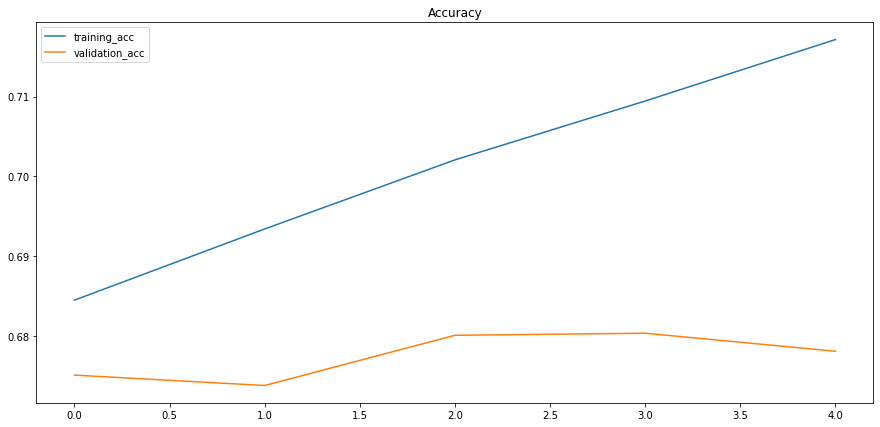

In [ ]:
#plot accuracy
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['accuracy'])
plt.plot(range(epochs), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

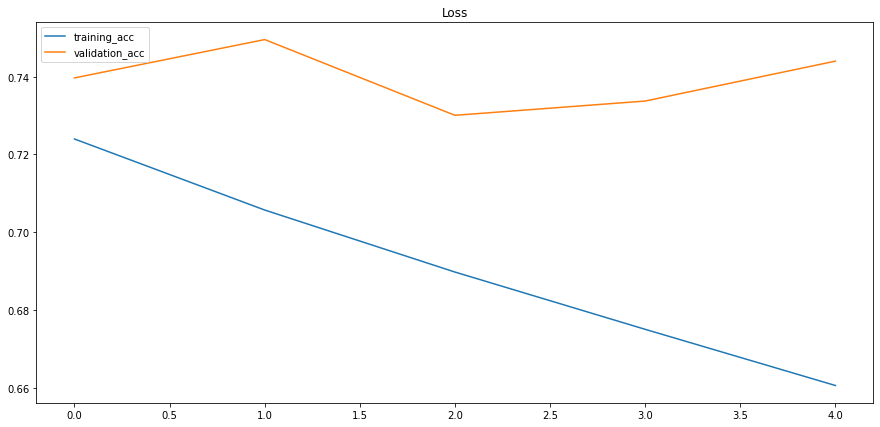

In [ ]:
#plot loss
plt.figure(figsize=(15, 7))
plt.plot(range(epochs), history.history['loss'])
plt.plot(range(epochs), history.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.title('Loss')

In [ ]:
model.evaluate(X_test_indices, Y_test)

6250/6250 [==============================] - 78s 12ms/step - loss: 0.7440 - accuracy: 0.6780


[0.7439811825752258, 0.6780449748039246]

In [ ]:
preds = model.predict(X_test_indices)

In [ ]:
model.save('/content/drive/My Drive/Master Thesis/Model/keras_gru_2015_2018_1000000')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Master Thesis/Model/keras_gru_2015_2018_1000000/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Master Thesis/Model/keras_gru_2015_2018_1000000/assets


In [ ]:
loaded_model = keras.models.load_model('/content/drive/My Drive/Master Thesis/Model/keras_gru_2015_2018_1000000')

In [ ]:
np.testing.assert_allclose(
    model.predict(X_test_indices), loaded_model.predict(X_test_indices)
)

In [ ]:
preds = loaded_model.predict(X_test_indices)

In [ ]:
stars_pred = np.argmax(preds, axis=1)+1

In [ ]:
confusion_matrix(np.argmax(Y_test, axis=1)+1, stars_pred)

array([[16067,  3382,   570,   103,   205],
       [ 4356,  8275,  3521,   389,   142],
       [  979,  4466, 12396,  5616,   925],
       [  307,   553,  5565, 28046, 18467],
       [  362,   154,   884, 13445, 70825]])

In [ ]:
print(classification_report(np.argmax(Y_test, axis=1)+1, stars_pred))

              precision    recall  f1-score   support

           1       0.73      0.79      0.76     20327
           2       0.49      0.50      0.49     16683
           3       0.54      0.51      0.52     24382
           4       0.59      0.53      0.56     52938
           5       0.78      0.83      0.80     85670

    accuracy                           0.68    200000
   macro avg       0.63      0.63      0.63    200000
weighted avg       0.67      0.68      0.67    200000

